```bash
export TASK_QUEUE_ENABLE="2"
export CPU_AFFINITY_CONF="2"
export HCCL_OP_EXPANSION_MODE="AIV"
export HCCL_DETERMINISTIC="false"
export PYTORCH_NPU_ALLOC_CONF="expandable_segments:True"
export INF_NAN_MODE_FORCE_DISABLE="1"
```

## Download

In [1]:
import os

os.environ["MODELSCOPE_CACHE"] = "weights"

In [2]:
# SDK模型下载
from modelscope import snapshot_download

snapshot_download('iic/CosyVoice2-0.5B', local_dir='pretrained_models/CosyVoice2-0.5B')
# snapshot_download('iic/CosyVoice-ttsfrd', local_dir='pretrained_models/CosyVoice-ttsfrd')
# snapshot_download("pengzhendong/wetext", local_dir='pretrained_models/wetext')
"snapshot_download done"

2025-08-26 09:21:51,219 - modelscope - INFO - Creating symbolic link weights/hub/iic/CosyVoice2-0___5B -> weights/hub/iic/CosyVoice2-0.5B.
2025-08-26 09:21:51,219 - modelscope - WARNING - Failed to create symbolic link weights/hub/iic/CosyVoice2-0___5B -> weights/hub/iic/CosyVoice2-0.5B: [Errno 2] No such file or directory: '/home/slog/tttttt/CosyVoice/weights/hub/iic/CosyVoice2-0___5B' -> 'weights/hub/iic/CosyVoice2-0.5B'


'snapshot_download done'

## Ready

In [3]:
import sys

sys.path.append("third_party/Matcha-TTS")
sys.path.append("third_party/async_cosyvoice")
sys.path.append("third_party/vllm")

In [4]:
from pathlib import Path

Path("./output").mkdir(exist_ok=True)

## Torch inference

In [5]:
import torchaudio

from cosyvoice.cli.cosyvoice import CosyVoice2
from cosyvoice.utils.file_utils import load_wav

2025-08-26 09:21:53,234 WARNING No module named 'torch_npu'


failed to import ttsfrd, use wetext instead


2025-08-26 09:21:53,513 WARNING No module named 'ais_bench', Tip:
    wget https://aisbench.obs.myhuaweicloud.com/packet/ais_bench_infer/0.0.2/ait/aclruntime-0.0.2-cp310-cp310-linux_aarch64.whl
    wget https://aisbench.obs.myhuaweicloud.com/packet/ais_bench_infer/0.0.2/ait/ais_bench-0.0.2-py3-none-any.whl
    pip install aclruntime-0.0.2-cp310-cp310-linux_aarch64.whl ais_bench-0.0.2-py3-none-any.whl
    


In [6]:
cosyvoice = CosyVoice2(
    "pretrained_models/CosyVoice2-0.5B",
    load_jit=True,
    load_trt=False,
    load_vllm=False,
    fp16=True,
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
/home/slog/tttttt/CosyVoice/.venv/lib/python3.11/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
2025-08-26 09:21:57,891 INFO input frame rate=25
/home/slog/tttttt/CosyVoice/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/slog/tttttt/CosyVoice/.venv/lib/python3.11/site-packages/pyworld/__init__.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package i

2025-08-26 09:22:01,951 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/revisions HTTP/1.1" 200 205
2025-08-26 09:22:02,054 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/repo/files?Revision=master&Recursive=True HTTP/1.1" 200 None
2025-08-26 09:22:02,163 DEBUG Starting new HTTPS connection (1): www.modelscope.cn:443


2025-08-26 09:22:02,498 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/revisions HTTP/1.1" 200 205
2025-08-26 09:22:02,600 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/repo/files?Revision=master&Recursive=True HTTP/1.1" 200 None


In [7]:
# NOTE if you want to reproduce the results on https://funaudiollm.github.io/cosyvoice2,
# please add text_frontend=False during inference
prompt_speech_16k = load_wav("./asset/zero_shot_prompt.wav", 16000)

In [8]:
print(cosyvoice.list_available_spks())

['中文女', '中文男', '日语男', '粤语女', '英文女', '英文男', '韩语女']


In [9]:
# wget https://www.modelscope.cn/models/iic/CosyVoice-300M-SFT/resolve/master/spk2info.pt
# 不支持流式，且输出有问题
for i, j in enumerate(
    cosyvoice.inference_sft(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜和深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "英文男",
        stream=False,
    )
):
    torchaudio.save("output/inference_sft_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)


  0%|          | 0/1 [00:00<?, ?it/s]2025-08-26 09:22:07,538 INFO synthesis text 收到好友从远方寄来的生日礼物，那份意外的惊喜和深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。


text: torch.Size([1, 51])
text_len: torch.Size([1])
llm_embedding: torch.Size([1, 192])
flow_embedding: torch.Size([1, 192])


2025-08-26 09:22:16,689 INFO yield speech len 11.36, rtf 0.8054920275446396
100%|██████████| 1/1 [00:09<00:00,  9.21s/it]

{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 256, kernel_size=(30,), stride=(15,), padding=(7,))}
{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 128, kernel_size=(6,), stride=(3,), padding=(1,))}
{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 64, kernel_size=(1,), stride=(1,))}


In [10]:
for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "希望你以后能够做的比我还好呦。",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

  0%|          | 0/1 [00:00<?, ?it/s]2025-08-26 09:22:17,059 INFO synthesis text 收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福，让我心中充满了甜蜜的快乐，笑容如花儿般绽放。


prompt_text: torch.Size([1, 15])
prompt_text_len: torch.Size([1])
llm_prompt_speech_token: torch.Size([1, 87])
llm_prompt_speech_token_len: torch.Size([1])
flow_prompt_speech_token: torch.Size([1, 87])
flow_prompt_speech_token_len: torch.Size([1])
prompt_speech_feat: torch.Size([1, 174, 80])
prompt_speech_feat_len: torch.Size([1])
llm_embedding: torch.Size([1, 192])
flow_embedding: torch.Size([1, 192])
text: torch.Size([1, 51])
text_len: torch.Size([1])


2025-08-26 09:22:27,022 INFO yield speech len 11.24, rtf 0.886376875575327
100%|██████████| 1/1 [00:10<00:00, 10.29s/it]

{'s_stft.shape': torch.Size([1, 18, 67441]),
 'self.source_downs[i]': Conv1d(18, 256, kernel_size=(30,), stride=(15,), padding=(7,))}
{'s_stft.shape': torch.Size([1, 18, 67441]),
 'self.source_downs[i]': Conv1d(18, 128, kernel_size=(6,), stride=(3,), padding=(1,))}
{'s_stft.shape': torch.Size([1, 18, 67441]),
 'self.source_downs[i]': Conv1d(18, 64, kernel_size=(1,), stride=(1,))}


In [11]:
# save zero_shot spk for future usage
assert (
    cosyvoice.add_zero_shot_spk(
        "希望你以后能够做的比我还好呦。", prompt_speech_16k, "my_zero_shot_spk"
    )
    is True
)

In [12]:
for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        "收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福,让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "",
        "",
        zero_shot_spk_id="my_zero_shot_spk",
        stream=False,
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)
#cosyvoice.save_spkinfo()

  0%|          | 0/1 [00:00<?, ?it/s]2025-08-26 09:22:27,266 INFO synthesis text 收到好友从远方寄来的生日礼物，那份意外的惊喜与深深的祝福,让我心中充满了甜蜜的快乐，笑容如花儿般绽放。


prompt_text: torch.Size([1, 15])
prompt_text_len: torch.Size([1])
llm_prompt_speech_token: torch.Size([1, 87])
llm_prompt_speech_token_len: torch.Size([1])
flow_prompt_speech_token: torch.Size([1, 87])
flow_prompt_speech_token_len: torch.Size([1])
prompt_speech_feat: torch.Size([1, 174, 80])
prompt_speech_feat_len: torch.Size([1])
llm_embedding: torch.Size([1, 192])
flow_embedding: torch.Size([1, 192])
text: torch.Size([1, 51])
text_len: torch.Size([1])


2025-08-26 09:22:35,594 INFO yield speech len 10.4, rtf 0.8007067671188941
100%|██████████| 1/1 [00:08<00:00,  8.34s/it]

{'s_stft.shape': torch.Size([1, 18, 62401]),
 'self.source_downs[i]': Conv1d(18, 256, kernel_size=(30,), stride=(15,), padding=(7,))}
{'s_stft.shape': torch.Size([1, 18, 62401]),
 'self.source_downs[i]': Conv1d(18, 128, kernel_size=(6,), stride=(3,), padding=(1,))}
{'s_stft.shape': torch.Size([1, 18, 62401]),
 'self.source_downs[i]': Conv1d(18, 64, kernel_size=(1,), stride=(1,))}


In [13]:
# fine grained control, for supported control, check cosyvoice/tokenizer/tokenizer.py#L248
for i, j in enumerate(
    cosyvoice.inference_cross_lingual(
        "在他讲述那个荒诞故事的过程中，他突然[laughter]停下来，因为他自己也被逗笑了[laughter]。",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/fine_grained_control_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

  0%|          | 0/1 [00:00<?, ?it/s]2025-08-26 09:22:35,839 INFO synthesis text 在他讲述那个荒诞故事的过程中，他突然[laughter]停下来，因为他自己也被逗笑了[laughter]。
2025-08-26 09:22:44,741 INFO yield speech len 10.12, rtf 0.8795896066507333
100%|██████████| 1/1 [00:09<00:00,  9.14s/it]

{'s_stft.shape': torch.Size([1, 18, 60721]),
 'self.source_downs[i]': Conv1d(18, 256, kernel_size=(30,), stride=(15,), padding=(7,))}
{'s_stft.shape': torch.Size([1, 18, 60721]),
 'self.source_downs[i]': Conv1d(18, 128, kernel_size=(6,), stride=(3,), padding=(1,))}
{'s_stft.shape': torch.Size([1, 18, 60721]),
 'self.source_downs[i]': Conv1d(18, 64, kernel_size=(1,), stride=(1,))}


In [ ]:
# instruct usage，河南话不行，广东话还行
for i, j in enumerate(
    cosyvoice.inference_instruct2(
        "收到好友从远那份意外的惊喜与深深的祝福让我心中充满了甜蜜的快乐，笑容如花儿般绽放。",
        "用河南话说这句话",
        prompt_speech_16k,
        stream=False,
    )
):
    torchaudio.save("output/instruct_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

  0%|          | 0/1 [00:00<?, ?it/s]2025-08-26 09:23:44,264 INFO synthesis text 收到好友从远那份意外的惊喜与深深的祝福让我心中充满了甜蜜的快乐，笑容如花儿般绽放。
2025-08-26 09:23:51,388 INFO yield speech len 11.36, rtf 0.6271640599613458
100%|██████████| 1/1 [00:07<00:00,  7.35s/it]

{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 256, kernel_size=(30,), stride=(15,), padding=(7,))}
{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 128, kernel_size=(6,), stride=(3,), padding=(1,))}
{'s_stft.shape': torch.Size([1, 18, 68161]),
 'self.source_downs[i]': Conv1d(18, 64, kernel_size=(1,), stride=(1,))}


In [15]:
# bistream usage, you can use generator as input, this is useful when using text llm model as input
# NOTE you should still have some basic sentence split logic because llm can not handle arbitrary sentence length
def text_generator():
    yield "收到好友从远方寄来的生日礼物，"
    yield "那份意外的惊喜与深深的祝福"
    yield "让我心中充满了甜蜜的快乐，"
    yield "笑容如花儿般绽放。"

for i, j in enumerate(
    cosyvoice.inference_zero_shot(
        text_generator(), "希望你以后能够做的比我还好呦。", prompt_speech_16k, stream=False
    )
):
    torchaudio.save("output/zero_shot_{}.wav".format(i), j["tts_speech"], cosyvoice.sample_rate)

2025-08-26 09:22:50,742 INFO get tts_text generator, will skip text_normalize!
  0%|          | 0/1 [00:00<?, ?it/s]

prompt_text: torch.Size([1, 15])
prompt_text_len: torch.Size([1])
llm_prompt_speech_token: torch.Size([1, 87])
llm_prompt_speech_token_len: torch.Size([1])
flow_prompt_speech_token: torch.Size([1, 87])
flow_prompt_speech_token_len: torch.Size([1])
prompt_speech_feat: torch.Size([1, 174, 80])
prompt_speech_feat_len: torch.Size([1])
llm_embedding: torch.Size([1, 192])
flow_embedding: torch.Size([1, 192])


AttributeError: 'generator' object has no attribute 'shape'

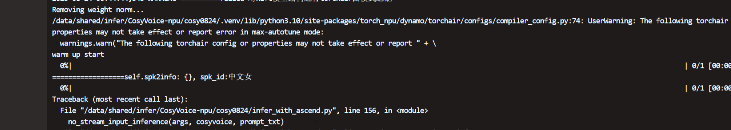

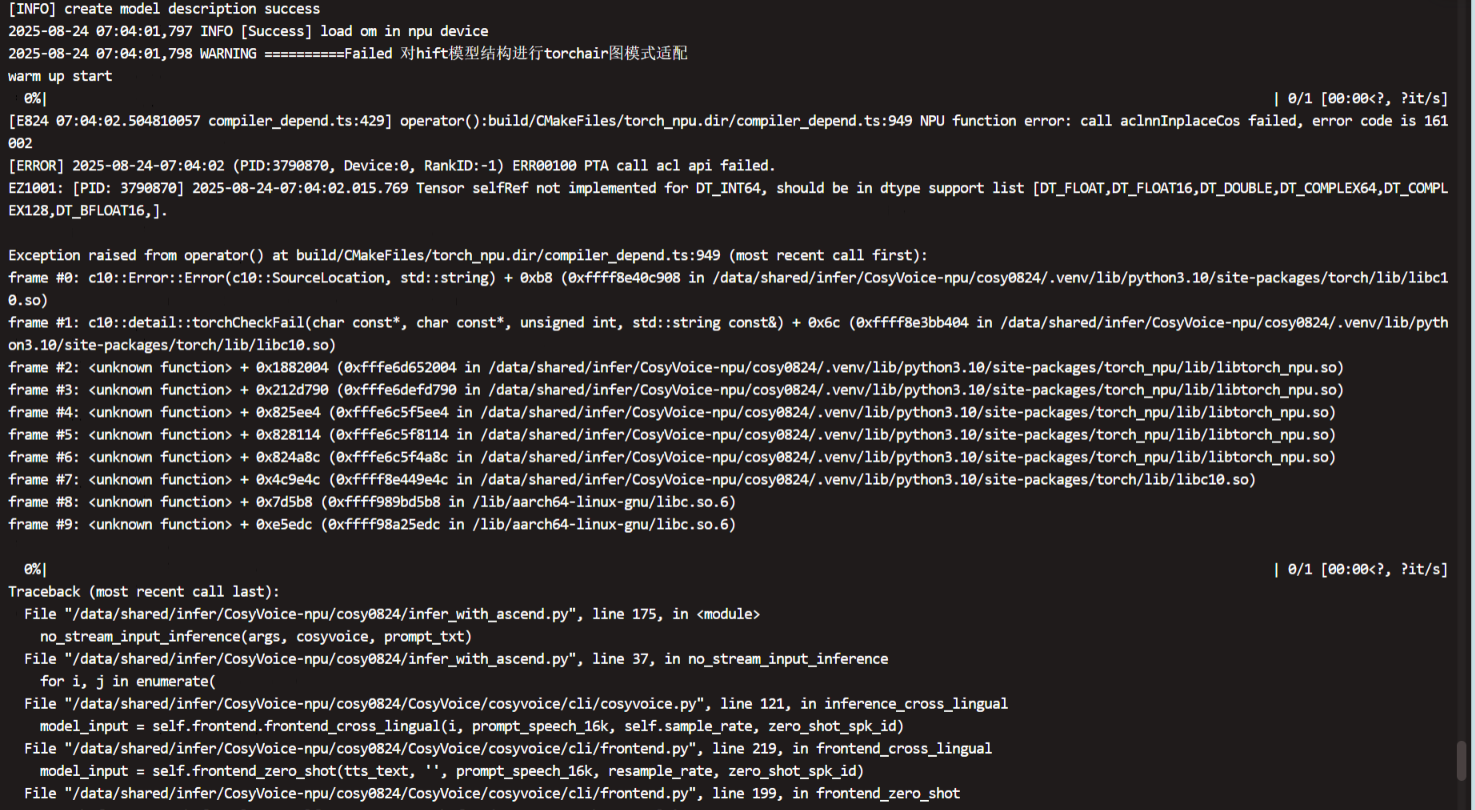
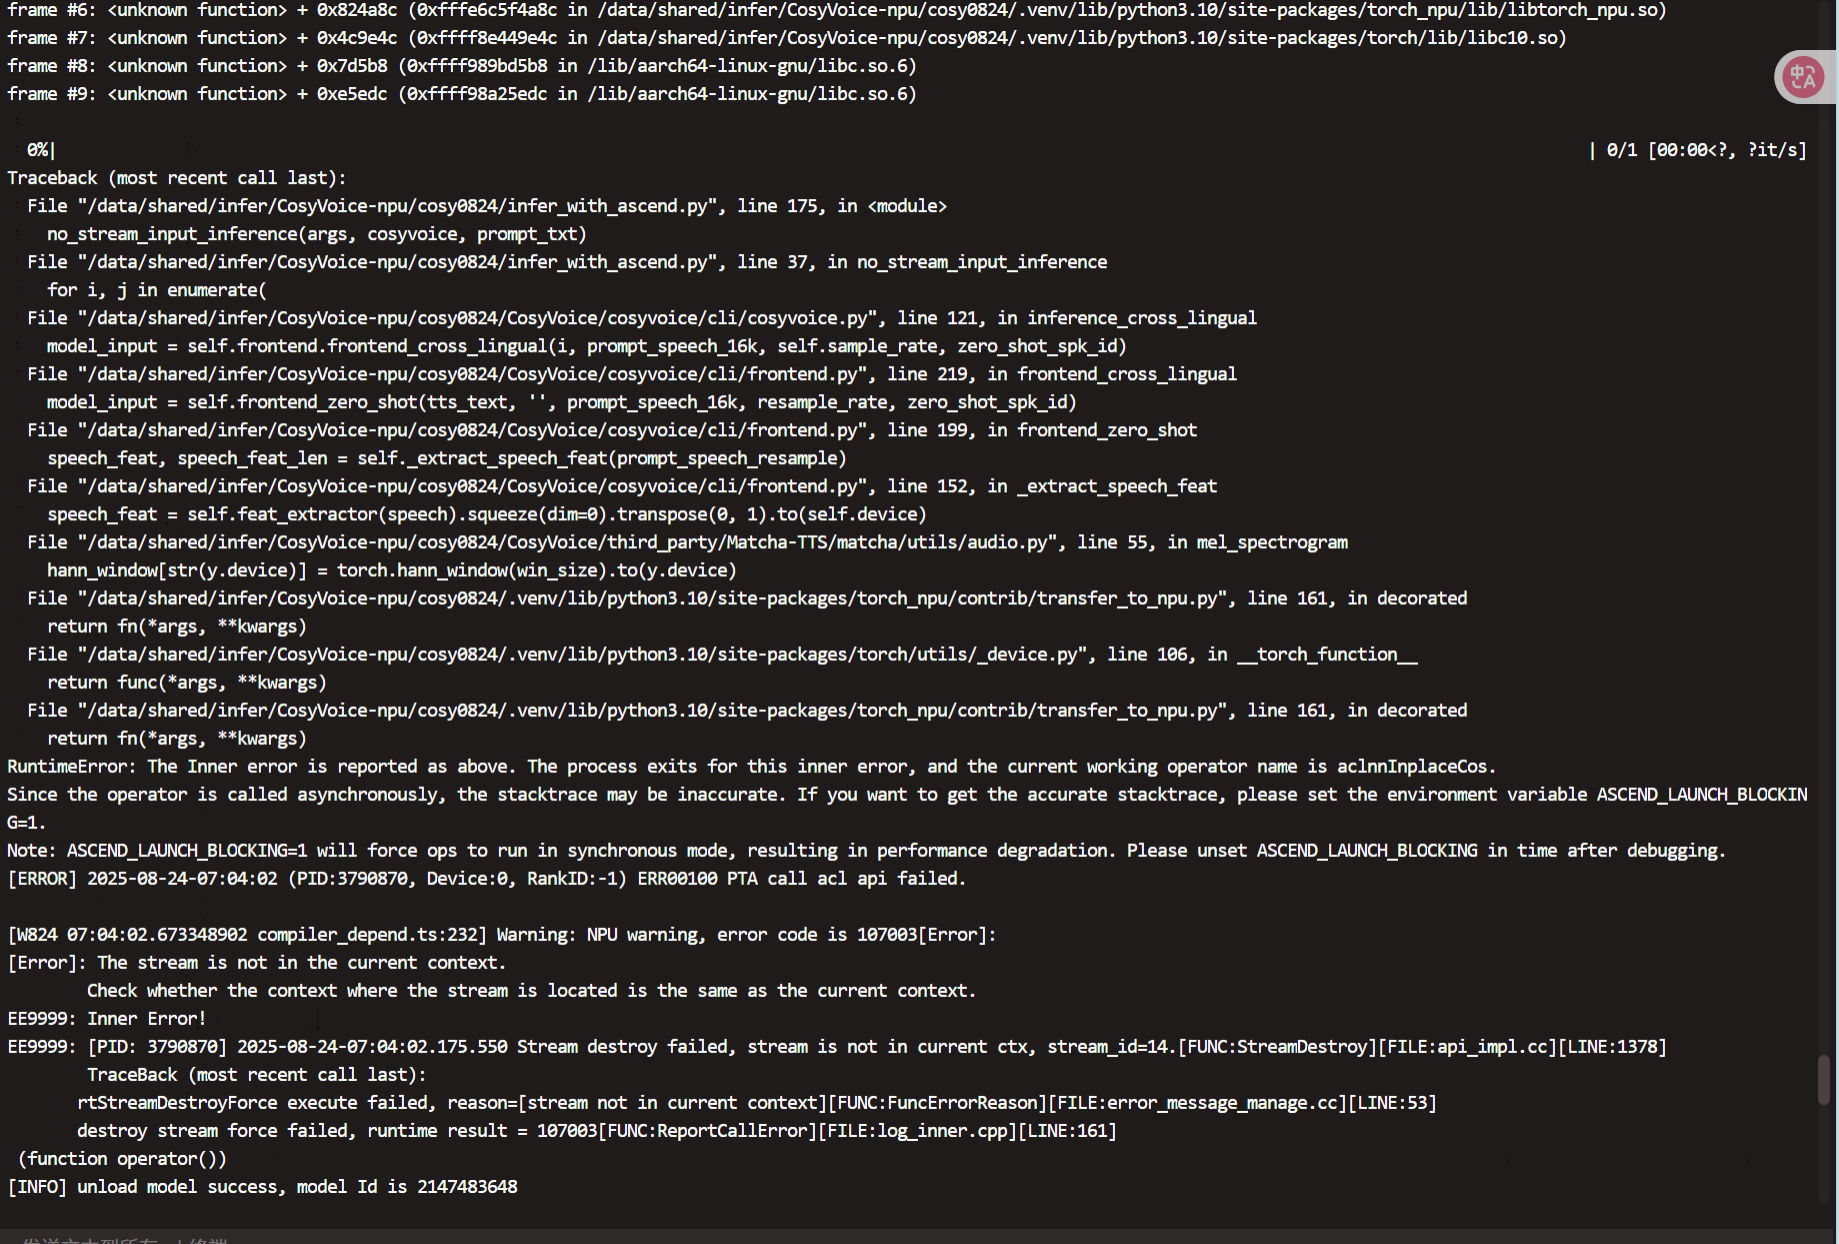

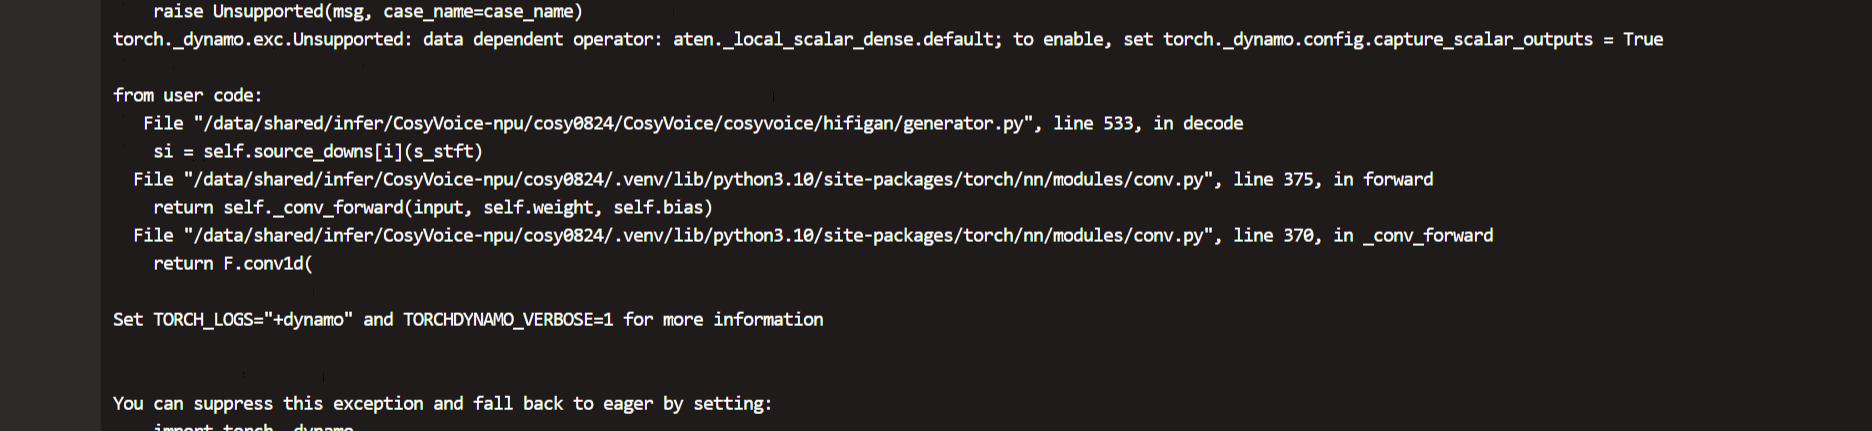

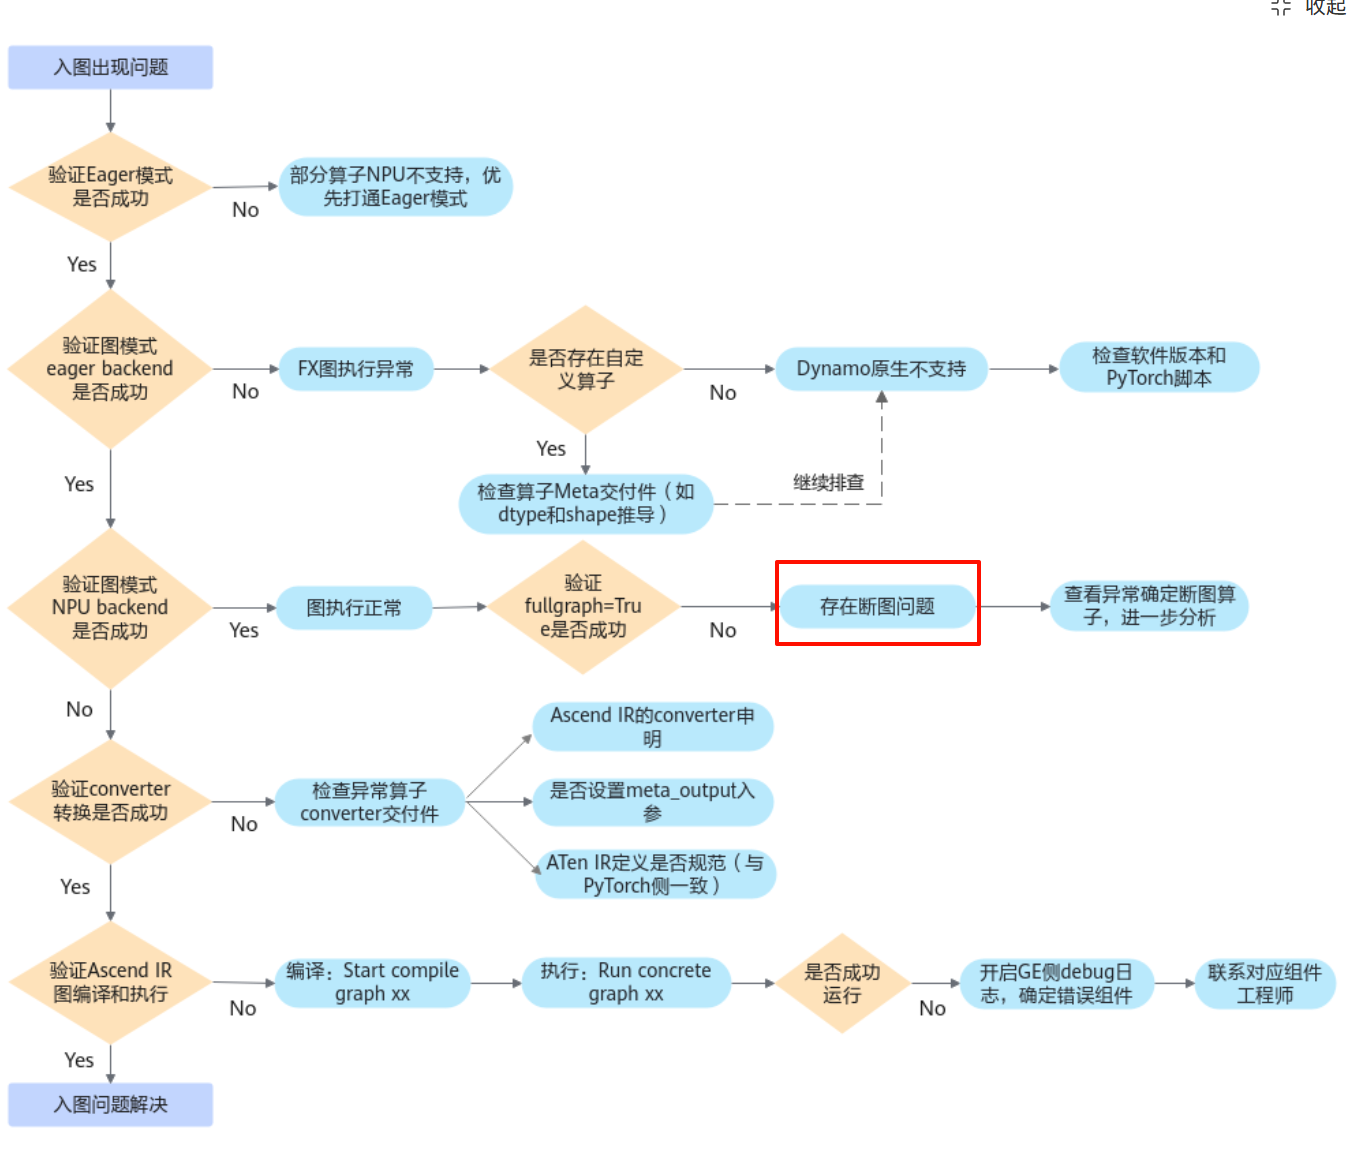

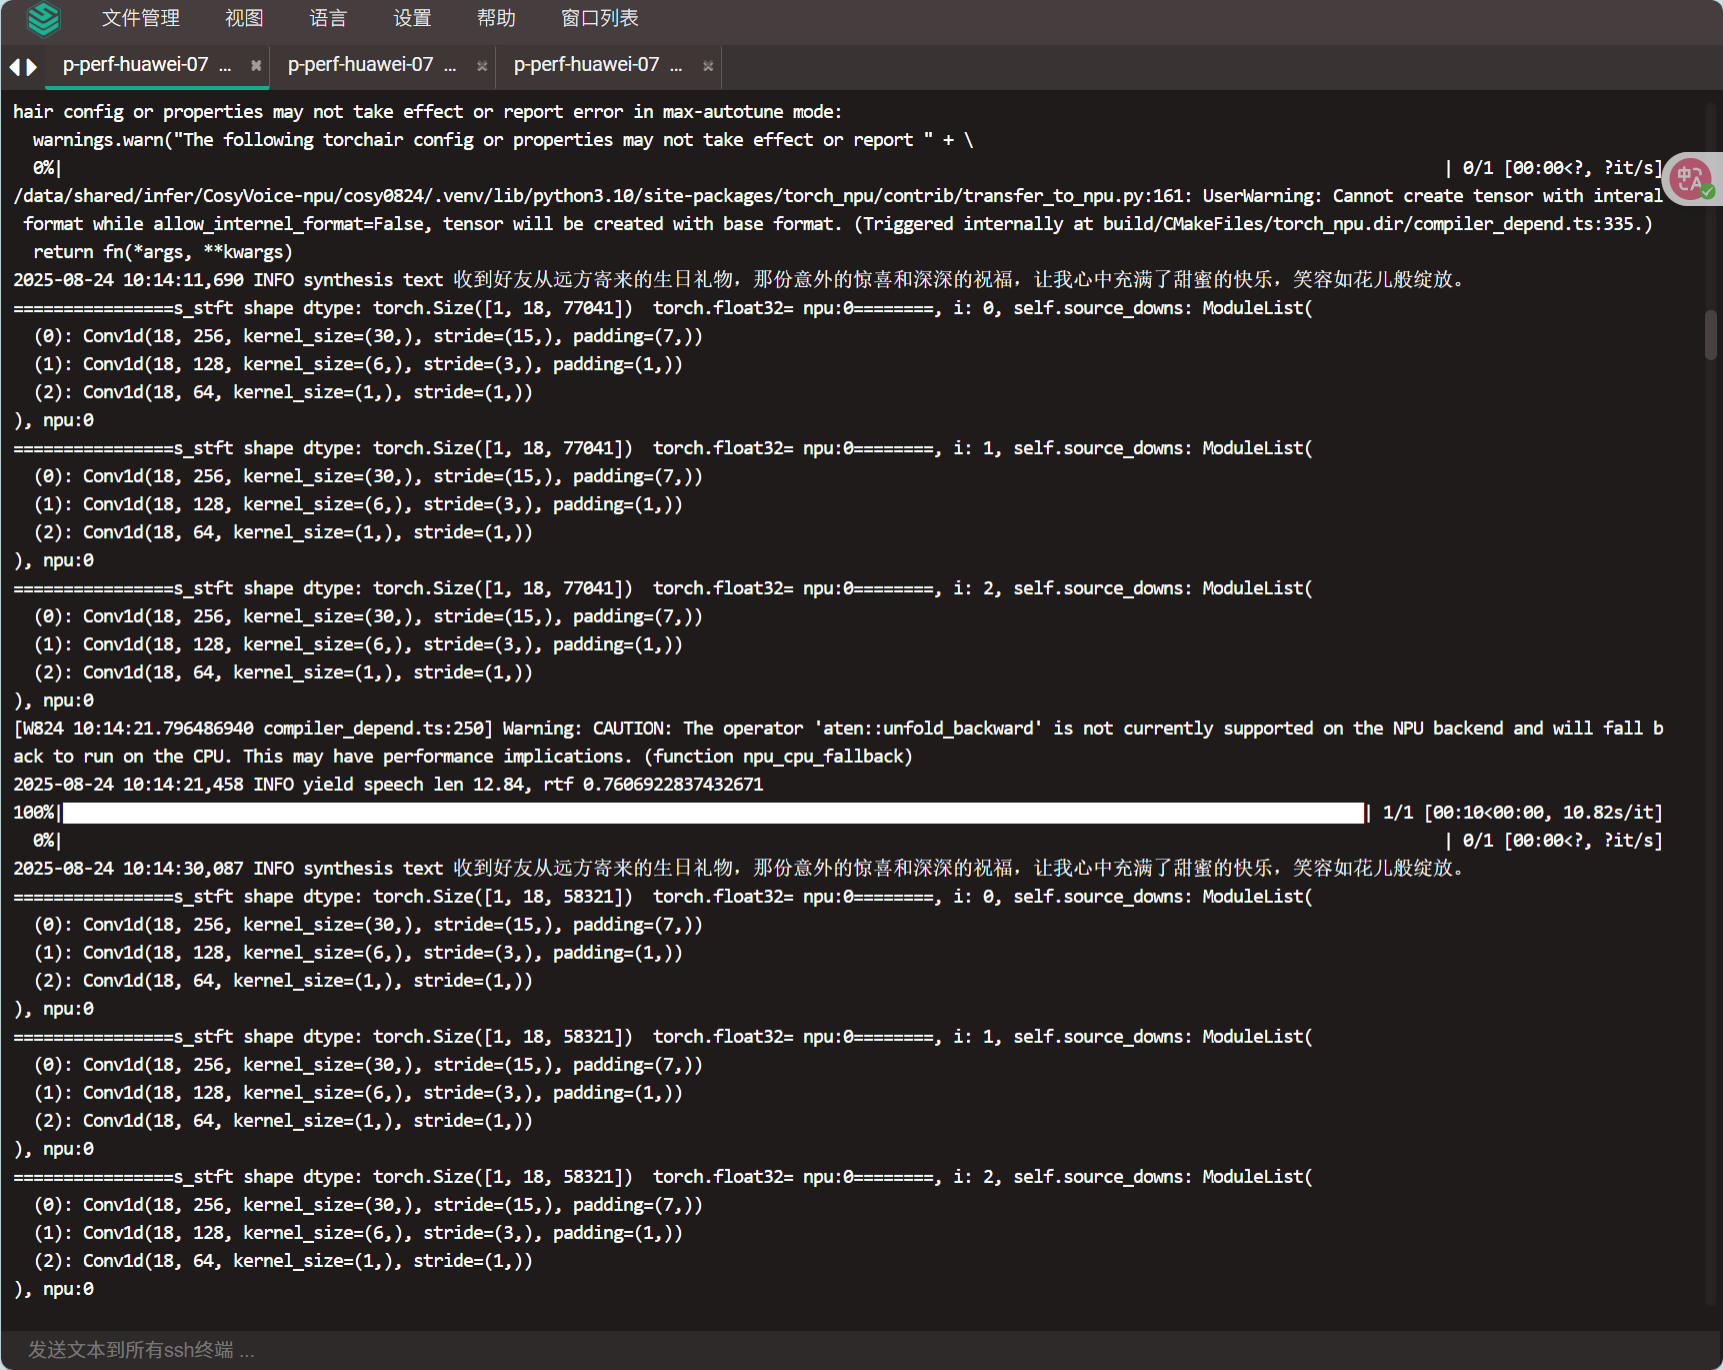